In [1]:
import scanpy as sc
# from CITEsort_rna.metadimm import MetaDIMM
import numpy as np
import pandas as pd
# from CITEsort.Visualize import plot_keymarker,visualize_tree
from Classifier.BTreeTraversal import BTreeTraversal
from Classifier.Visualize import plot_keymarker,visualize_tree, visualize_classifytree
from Classifier.BTree import BTree
from Classifier.adtReSplit import FakeFeatureSeparate
import pickle

In [2]:
# id ='1'
# data = pd.read_csv('../data/4tumor/subdata/ADT_'+id+'.csv',index_col=0)
# data = pd.read_csv('../SeuratV4/subdata/'+id+'_ADT.csv', sep=',',index_col=0, header=0)
id='7_5/new_0'
f = open('../output/'+id+'/tree_retrain.pickle','rb')
# f = open('../data/4tumor/output/ADT_'+id+'/tree.pickle','rb')
tree = pickle.load(f)
f.close()
# traversal = BTreeTraversal(tree)

In [21]:
# id = '4_5/4_50'
# data = sc.read_h5ad('../SeuratV4/subdata/'+id+'_RNA.h5ad')
# data = sc.read_10x_h5('../SeuratV3/filtered_feature_bc_matrix.h5')
# data = sc.read_h5ad('../data/covid19/rnadata.h5ad')
adata = sc.read_h5ad('../data/covid19/COMBAT-CITESeq-EXPRESSION-ATLAS.h5ad')
# label = pd.read_csv('../SeuratV3/metadata_seuratV3.txt',sep='\t')

In [4]:
# data.var_names
tree.artificial_w.index#.intersection(data.var_names)
# data[data.obs_names,:]
data.var_names_make_unique() 

In [13]:
def classify(indices, node):
    newtree = BTree(node.key)
    newtree.indices = indices
    if node.key == ('leaf',):
        # print(len(indices),newtree.key)
        return newtree
    # print(len(indices),newtree.key)
    w = node.artificial_w.loc[node.artificial_w.index.intersection(data.var_names)]
    # print(w)
    adata = data[indices, w.index].copy()
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    try:
        feature = adata.X.dot(w.values)
        # feature = np.dot(adata.X.toarray(), node.artificial_w.values)
    except:
        feature = np.dot(adata.X, w.values)
    feature = pd.DataFrame(feature, index=adata.obs_names, columns=[node.key[0]])
    
    newtree = FakeFeatureSeparate(feature, newtree, 0.1, min(node.embedding),max(node.embedding))
    newtree.artificial_w = feature
    newtree.val_cnt = node.val_cnt
    # return newtree
    if node.key != ('leaf',):
        if newtree.w_l > 0:
            newtree.left = classify(newtree.left_indices, node.left)
        if newtree.w_r > 0:
            newtree.right = classify(newtree.right_indices, node.right)
    return newtree

In [14]:
newtree = classify(data.obs_names, tree)

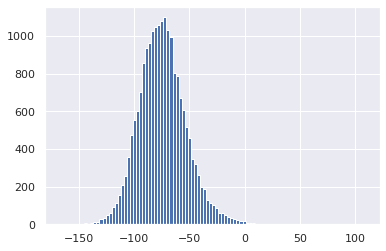

[-22.09091567993164, 26.916030883789062]

In [47]:
import matplotlib.pyplot as plt

plt.hist(newtree.right.left.left.artificial_w, bins=100)

plt.show()
tree.left.right.embedding

In [15]:
import os
id = '7_5/'
output = '../output/'+id + 'classify_covid19'
if not os.path.exists(output):
    os.mkdir(output)
# visualize_tree(tree, adtdata[i], output, 'tree', compact=compact_flag, rnadata=rnadata[i].copy())
visualize_classifytree(newtree, output, 'tree')
f = open(output+'/tree.pickle','wb')
pickle.dump(newtree,f)
f.close()
print('generate labels.')
traversal = BTreeTraversal(newtree,save_min_BIC=False)
leaves_labels = traversal.get_leaf_label()
# leaves_labels.to_csv(output + '/leaf_labels.csv')

/home/xinzhu/Desktop/git-test/CITE-sortV2
generate labels.


In [17]:
# data = scanpy_flow(data.copy)
leaves_labels.index = leaves_labels.iloc[:,0]
data.obs['pred'] = leaves_labels['Label']
# sc.pl.umap(data, color=['pred','major_subset'])

In [25]:
data.obs_names

Index(['AAACCTGAGAGGGCTT-1', 'AAACCTGAGAGTAAGG-1', 'AAACCTGAGCGTAGTG-1',
       'AAACCTGAGCTGAAAT-1', 'AAACCTGAGCTTATCG-1', 'AAACCTGAGGCCCTTG-1',
       'AAACCTGAGGTGGGTT-1', 'AAACCTGAGTACATGA-1', 'AAACCTGCAAACCTAC-1',
       'AAACCTGCAAAGGAAG-1',
       ...
       'TTTGTCAGTTCAACCA-1', 'TTTGTCAGTTGCTCCT-1', 'TTTGTCATCACCACCT-1',
       'TTTGTCATCACGCATA-1', 'TTTGTCATCAGTGTTG-1', 'TTTGTCATCCTTAATC-1',
       'TTTGTCATCGATAGAA-1', 'TTTGTCATCGGCCGAT-1', 'TTTGTCATCTAACGGT-1',
       'TTTGTCATCTGACCTC-1'],
      dtype='object', length=22017)

In [41]:
label=label[~label.index.duplicated()]
# data.obs_names.intersection(label.index)

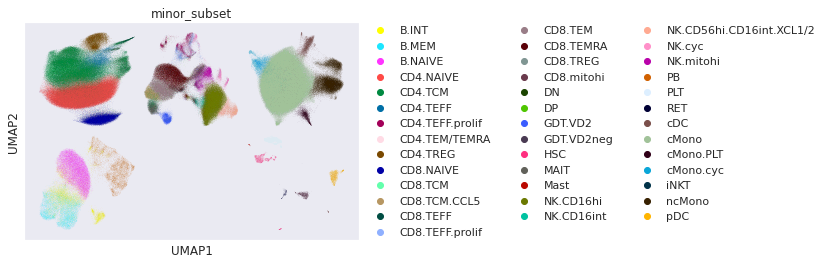

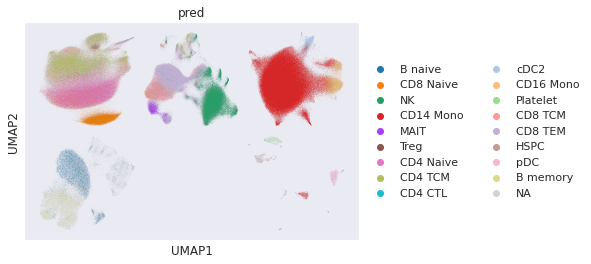

In [18]:
data.obs['pred'] = data.obs['pred'].astype('category')
data.obs['pred'] = data.obs['pred'].cat.rename_categories(new_categories= {'23_leaf':'CD4 TCM','22_leaf': "CD4 Naive",
'24_leaf':'CD4 CTL','17_leaf':'CD14 Mono','25_leaf':'cDC2','20_leaf':'MAIT','32_leaf':'pDC','15_leaf':'NK','9_leaf':'B memory','10_leaf':'B naive',
'28_leaf':'Platelet','21_leaf':'Treg','27_leaf':'CD16 Mono','12_leaf':'CD8 Naive','29_leaf':'CD8 TCM','30_leaf':'CD8 TEM','31_leaf':'HSPC'})
# label.index = [x[2:] for x in label.index]
# label.index = [x[:-2]+'-1' for x in label.index]
# data.obs['label_l2'] = label['celltype.l2']#.astype(str)
sc.pl.umap(data[data.obs['minor_subset']!='nan'], color=['minor_subset'])
sc.pl.umap(data[data.obs['minor_subset']!='nan'], color=['pred'])

In [9]:
def scanpy_flow(adata,if_log=True):
    sc.settings.set_figure_params(dpi=80, facecolor='white')
    
    if if_log:
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata,min_disp=0.1)
    adata = adata[:,adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10, zero_center=False)
    # adata.X = preprocessing.scale(adata.X)
    sc.tl.pca(adata, svd_solver='arpack',n_comps=50)
    # sc.pl.pca_variance_ratio(adata, log=True)
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    return adata

In [69]:
tree.left.left.left.right.right.loss.detach().numpy()

array(819.44556, dtype=float32)

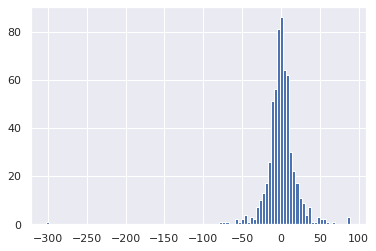

In [21]:
# traversal = BTreeTraversal(tree,save_min_BIC=False)
node = tree.left.right.right
# node = traversal.get_node(8)
plt.hist(node.artificial_w, bins=100)
plt.show()

In [37]:
adata.X[:,150].max()
# sc.pp.highly_variable_genes(adata,min_disp=0.1)
# sc.pl.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)

: 

: 

In [9]:
def dfs(crossnode, adtdata, rnadata, merge_cutoff, useADT=True):
    nodelist = crossnode.nodelist
    lnodelist, rnodelist, ladt, radt, lrna, rrna = [], [], {}, {}, {}, {}
    for i in range(len(nodelist)):
        node = nodelist[i]
        if node != None:
            lnodelist.append(node.left)
            rnodelist.append(node.right)
            if node.key != ('leaf',):
                if useADT:
                    if len(adtdata[i]) > 0:
                        ladt[i], radt[i] = adtdata[i].loc[node.left_indices,:], adtdata[i].loc[node.right_indices,:]
                    else:
                        ladt[i], radt[i] = [],[]
                lrna[i], rrna[i] = rnadata[i][node.left_indices,:], rnadata[i][node.right_indices,:]
            else:
                ladt[i], radt[i], lrna[i], rrna[i] = [],[],[],[]
    lcrossnode = CrossNode(lnodelist, modelnode=crossnode.modelnode.left)
    rcrossnode = CrossNode(rnodelist, modelnode=crossnode.modelnode.right)
    crossnode.left = dfs(lcrossnode, ladt, lrna, merge_cutoff, useADT)
    crossnode.right = dfs(rcrossnode, radt, rrna, merge_cutoff, useADT)
    return crossnode

In [10]:
id='5_4'

adata = sc.read_h5ad('../SeuratV3/subdata/'+id+'_RNA.h5ad')
label = adata.obs['label']
label.name = 'cell_type'
# adata = sc.read_h5ad('../simulator_out/RNA_simulator_'+id+'.h5ad')

# label = pd.read_csv('../simulator_out/droplets_composition_'+id+'.csv',index_col=0)
# label['cell_type'] = label.loc[:,'0'].astype(str)
# label.index = label.index.astype(str)
# adata.obs['label'] = label['cell_type']

f = open('../output/'+id+'_test/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)
md = MetaDIMM()
adata = adata[tree.indices,:]
# adata = md.filter(adata)
adata = md.preprocess(adata, normalize=True, log1p=True, hvg=False, scale=False)

pred_rna = pd.read_csv('../output/'+id+'_test/leaf_labels.csv',index_col=0)
pred_rna.index  = pred_rna.index.astype(str)
adata.obs['pred_rna'] = pd.Categorical(pred_rna['Label'])
# sc.tl.rank_genes_groups(adata, groupby='pred_rna', method='t-test')

NameError: name 'MetaDIMM' is not defined

In [ ]:
f = open('../output/'+id+'_test/tree.pickle','rb')
# f = open('CITEsort_out/SeuratV3_main_ct_smooth2/tree.pickle','rb')
tree = pickle.load(f)
f.close()
traversal = BTreeTraversal(tree)

In [ ]:
tp = pd.read_csv('../data/bmmc/RNA_PBMC_1.csv')
# tp.T.to_csv('../data/bmmc/RNA_BMMC_1.csv')

In [ ]:
tp.iloc[:2,:2]

,PBMC_D4T1.AAACCCAAGATTGTGA.1,PBMC_D4T1.AAACCCACATCGGTTA.1
0,0,0
1,0,0


In [ ]:
idnew = '4_8'

adata_new = sc.read_h5ad('../data/tumor/CZWY_celltype.h5ad')
# adata_new = sc.read_csv('../data/bmmc/RNA_BMMC_2.csv').T
# adata_new = sc.read_h5ad('../SeuratV4/subdata/'+idnew+'_RNA.h5ad')
# adata_new = sc.read_h5ad('../simulator_out/RNA_simulator_'+idnew+'.h5ad')
# sc.pp.filter_cells(adata_new, min_genes=100)
# adata_npp = md.preprocess(adata_new, normalize=True, log1p=True, hvg=False, scale=True)

In [ ]:
sc.tl.pca(adata_sub[:,genes], n_comps=5)

## Fine tune leaf nodes

In [ ]:
# nodeID = [6,13]
# nodelist, leaves_labels = traversal.get_leaf_label(finetune=True, method='bfs',nodeID=nodeID)
# leaves_labels.to_csv('../output/'+id+'_rna/cut_leaf_labels.csv')
# adata.obs['cutpred'] = leaves_labels['Label']

In [ ]:
# adata_new = adata_new.T
adata_new.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [ ]:
adata_npp = adata_new.copy()

In [ ]:
adata_npp = adata


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


newdict = dict()
dedict = dict()
coefdict = dict()
proba_dict = dict()
newdict[0] = adata_npp.obs_names
ind = 0
# pred_new = pd.Series(index=adata_new.obs_names,dtype='object')
nodelist = traversal.nodelist

for i in range(len(nodelist)):
    node = nodelist[i]
    nodelist[i].ind = [i for i in range(len(traversal.nodename)) if len(traversal.nodelist[i].indices)==len(node.indices)][0]

for node in nodelist:
    if node.left != None:
        
        # if node.ind == 24:
        #     pred_new.loc[newdict[node.ind]] = 16
        #     continue
        adata_sub = adata[node.indices,:].copy()
        sc.pp.filter_genes(adata_sub, min_cells=3)
        adata_sub.obs['node_split'] = pd.Series(dtype='object')
        adata_sub.obs['node_split'].loc[set(node.left.indices)&set(node.indices)] = str(0)
        adata_sub.obs['node_split'].loc[set(node.right.indices)&set(node.indices)] = str(1)
        sc.tl.rank_genes_groups(adata_sub, groupby='node_split', method='t-test', n_genes=4000)
        if len(adata_sub) > 500 and len(adata_sub)<5000:
            ngenes = 200
        else:
            ngenes = 1000
        DE_genes = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names'][:ngenes])
        genes = list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1']))&set(adata_npp.var_names))

        clf = LinearDiscriminantAnalysis()
        clf.fit(adata_sub[adata_sub.obs['node_split'].isin(['0','1']),genes].X.toarray(), adata_sub[adata_sub.obs['node_split'].isin(['0','1']),:].obs['node_split'])

        
        
    #     if len(newdict[ind]) == 0:
    #         adata_sub = adata_npp[False,genes].copy()
    #         pred = pd.Series('2',index=adata_sub.obs_names)
    #     else:
    #         adata_sub = adata_npp[newdict[ind],genes].copy()
    #         pred = pd.Series(clf.predict(adata_sub.X),index=adata_sub.obs_names)
            
    #         proba = clf.predict_proba(adata_sub.X)
    #         # print(proba.shape,proba[:2,:2])
    #     maxind = max(newdict.keys())
        
        dedict[node.left.ind] = DE_genes.loc[:,'0'].values
        dedict[node.right.ind] = DE_genes.loc[:,'1'].values
        coefdict[node.ind] = clf.coef_
    #     proba_dict[node.left.ind] = pd.Series([proba[i,0] for i in range(len(pred)) if pred.iloc[i]=='0'],index=adata_sub[pred=='0',:].obs_names)
    #     proba_dict[node.right.ind] = pd.Series([proba[i,1] for i in range(len(pred)) if pred.iloc[i]=='1'],index=adata_sub[pred=='1',:].obs_names)
    #     newdict[node.left.ind] = [pred.index[i] for i in range(len(pred)) if proba[i,0]>0.95 and pred.iloc[i]=='0']
    #     newdict[node.right.ind] = [pred.index[i] for i in range(len(pred)) if proba[i,1]>0.95 and pred.iloc[i]=='1']
    #     print(node.left.ind,node.right.ind)
    #     # newdict[node.right.ind] = adata_sub[pred=='1',:].obs_names
        
    # if node.key == ('leaf',):
    #     print(node.ind)
    #     # if node.ind == 12:
    #     #     pred_new.loc[[newdict[node.ind][i] for i in range(len(newdict[node.ind])) if proba_dict[node.ind].iloc[i]>0.99 and proba_dict[2].loc[newdict[node.ind][i]]>0.99]] = node.ind
    #     #     ind = ind+1
    #     #     continue
    #     # if node.ind == 25:
    #     #     pred_new.loc[[newdict[node.ind][i] for i in range(len(newdict[node.ind])) if proba_dict[node.ind].iloc[i]>0.999 ]] = node.ind
    #     #     ind = ind+1
    #     #     continue
    #     pred_new.loc[[newdict[node.ind][i] for i in range(len(newdict[node.ind])) if proba_dict[node.ind].iloc[i]>0.99]] = node.ind

    ind = ind+1
    # break

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

queue = [] 
newdict = dict()
dedict = dict()
queue.append(tree) 
newdict[0] = adata_npp.obs_names
ind = 0
pred_new = pd.Series(index=adata_new.obs_names,dtype='object')

while(len(queue) > 0): 
    node = queue.pop(0) 
    if node.left is not None:
        queue.append(node.left)
        queue.append(node.right) 

        adata_sub = adata[node.indices,:].copy()
        sc.pp.filter_genes(adata_sub, min_cells=3)
        adata_sub.obs['node_split'] = pd.Series(dtype='object')
        adata_sub.obs['node_split'].loc[node.left.indices] = str(0)
        adata_sub.obs['node_split'].loc[node.right.indices] = str(1)
        sc.tl.rank_genes_groups(adata_sub, groupby='node_split', method='t-test', n_genes=2000)
        DE_genes = pd.DataFrame(adata_sub.uns['rank_genes_groups']['names'][:1000])
        genes = list(set(list(DE_genes.loc[:,'0'])+list(DE_genes.loc[:,'1'])))

        clf = LinearDiscriminantAnalysis()
        clf.fit(adata_sub[adata_sub.obs['node_split'].isin(['0','1']),genes].X, adata_sub[adata_sub.obs['node_split'].isin(['0','1']),:].obs['node_split'])
    
        adata_sub = adata_npp[newdict[ind],genes].copy()
        pred = pd.Series(clf.predict(adata_sub.X),index=adata_sub.obs_names)
        maxind = max(newdict.keys())
        newdict[maxind+1] = adata_sub[pred=='0',:].obs_names
        newdict[maxind+2] = adata_sub[pred=='1',:].obs_names
        dedict[maxind+1] = DE_genes.loc[:,'0'].values
        dedict[maxind+2] = DE_genes.loc[:,'1'].values
        print(ind)
    else:
        pred_new.loc[newdict[ind]] = ind
    ind = ind+1
    # break

/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


1


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


2


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


3


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


4


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


5


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


6


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


9


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


10


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


14


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


16


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


17
22


/home/xinzhu/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/xinzhu/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [18]:
data.obs['pred_label'] = data.obs['pred'].cat.rename_categories(new_categories= {'23_leaf':'CD4 Memory','22_leaf': "CD4 Naive",'24_leaf':'CD4 CTL','17_leaf':'CD14 Mono','25_leaf':'cDC2','20_leaf':'MAIT and gdT','22_leaf':'pDC','15_leaf':'NK','9_leaf':'B Memory','10_leaf':'B Naive','28_leaf':'Platelet','21_leaf':'Treg','27_leaf':'CD16 Mono','12_leaf':'CD8 Naive','29_leaf':'CD8 TCM','30_leaf':'CD8 TEM','31_leaf':'HSPC'})

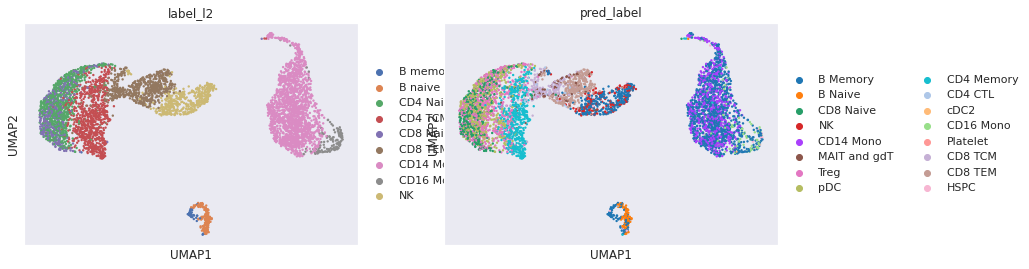

In [19]:
# sc.pp.scale(data)
# sc.tl.pca(data,n_comps=50)
# sc.pp.neighbors(data)
# sc.tl.umap(data)
# leaves_labels.index = leaves_labels.iloc[:,0]
# data.obs['pred'] = leaves_labels['Label']
sc.pl.umap(data, color=['label_l2','pred_label'])

In [ ]:
sc.tl.pca(adata_npp,n_comps=50)
sc.pp.neighbors(adata_npp)
sc.tl.umap(adata_npp)


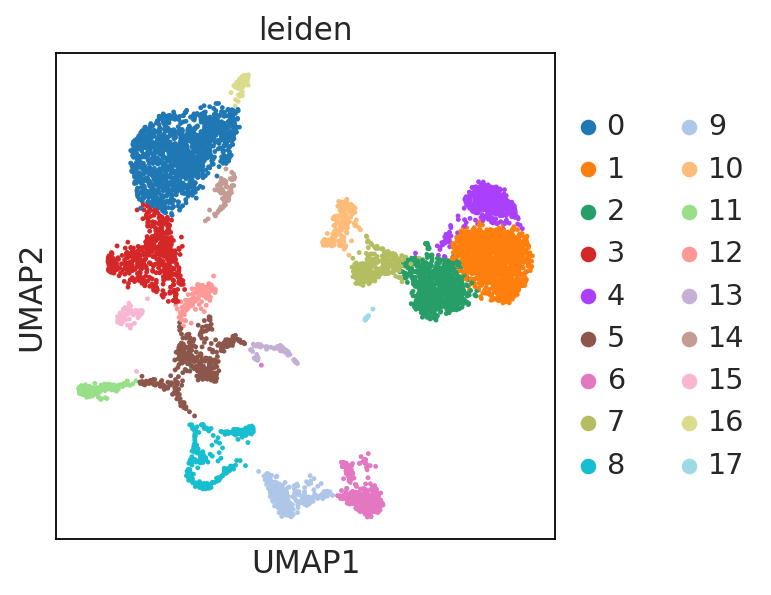

In [ ]:
sc.tl.leiden(adata_npp, resolution=0.5)
sc.pl.umap(adata_npp, color='leiden')

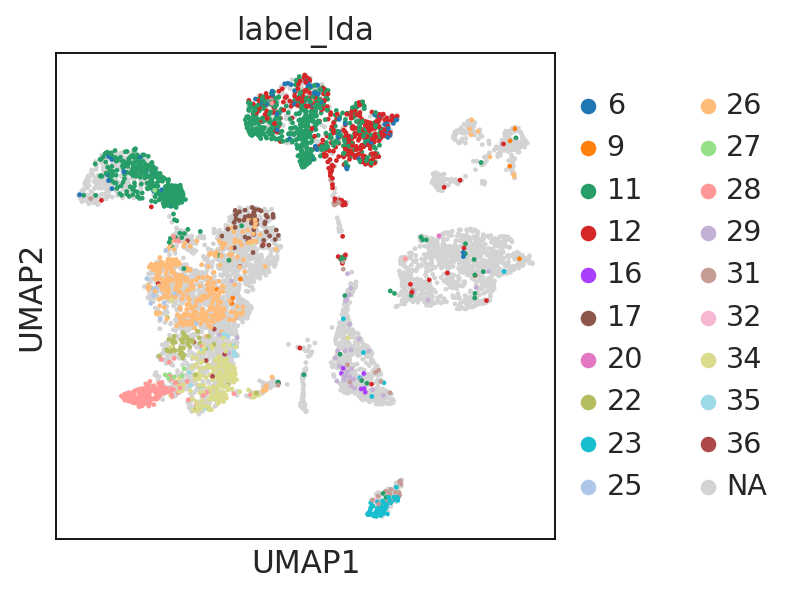

In [ ]:
adata_npp.obs['label_lda'] = pd.Categorical(pred_new)
sc.pl.umap(adata_npp,color='label_lda')

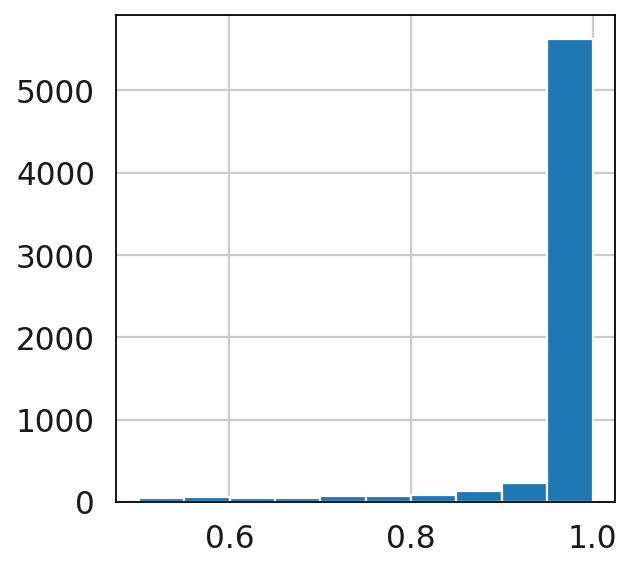

In [ ]:
import matplotlib.pyplot as plt

plt.hist(proba_dict[1],bins=10)
plt.show()

In [ ]:
adata_npp.obs['label'].value_counts()

CD4 T        1910
nan          1546
CD14 Mono    1282
B             806
CD8 Naive     457
CD8 T         214
NK            117
Name: label, dtype: int64

In [ ]:

genes = list(set(list(dedict[7])+list(dedict[8])))#&set(adata_npp.var_names)
# adata_sub = adata_npp[list(set(newdict[18])-set(adata_npp[adata_npp.obs['leiden'].isin(['3','15']),:].obs_names)),genes].copy()
# adata_sub = adata_npp[newdict[18],genes].copy()
adata_sub = adata[traversal.nodelist[3].indices,genes].copy()
# adata_sub = adata[adata.obs['label_l2'].isin(['CD8 TCM','CD8 TEM','CD4 TEM']),genes].copy()
y = np.dot(adata_sub.X,coefdict[3].T) 

In [ ]:
adata_sub.obs['label'].cat.categories

Index(['CD4 Memory', 'CD4 Naive', 'CD8 Effector_1', 'CD8 Effector_2',
       'CD8 Memory_1', 'CD8 Memory_2', 'CD8 Naive', 'CD16 Mono', 'Memory B',
       'NK', 'Naive B', 'cDC2'],
      dtype='object')

In [ ]:
len(adata_sub.obs['pred_rna'].cat.categories)

1

In [ ]:
# adata_sub.obs['label_plt'] = adata_sub.obs['label'].cat.rename_categories(new_categories={'CD16 Mono':0,'cDC2':1,'NK':3})#{'CD14 Mono':0,'Platelet':1,'Plasmablast':2,'cDC2':3})'CD4 TEM' :1,'CD8 Naive':2,'CD8 TCM' :3,'CD4 Naive':4})
# adata_sub.obs['label_plt'] = adata_sub.obs['pred_rna'].cat.rename_categories(new_categories={'1_leaf':0, '14_leaf':1})#,'17_leaf':2,'18_leaf':3})
adata_sub.obs['label_plt'] = adata_sub.obs['pred_rna'].cat.rename_categories(new_categories=range(5))
# adata_sub.obs['label_plt'] = adata_sub.obs['label_lda'].astype(int)

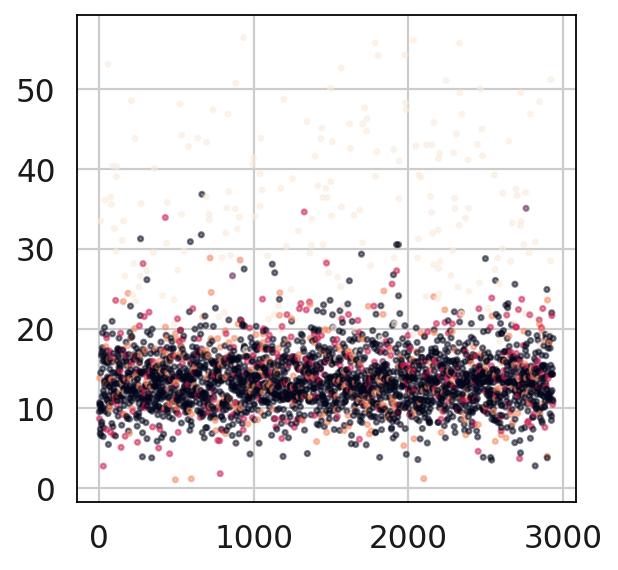

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(range(len(y)),y[:,0],s=5,alpha=0.5,c=adata_sub.obs['label_plt'].values)
# plt.hist(y,bins=100)
plt.show()
# plt.scatter(y[[i for i in range(len(y)) if newdict[8][i] in proba_dict[15].index],0],list(proba_dict[15]),s=5,alpha=0.5)
# plt.scatter(y[[i for i in range(len(y)) if newdict[8][i] in proba_dict[16].index],0],list(proba_dict[16]),s=5,alpha=0.5)


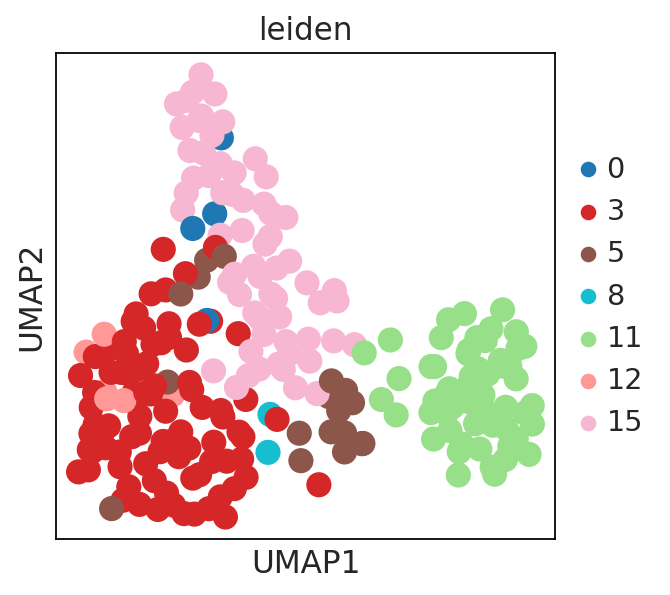

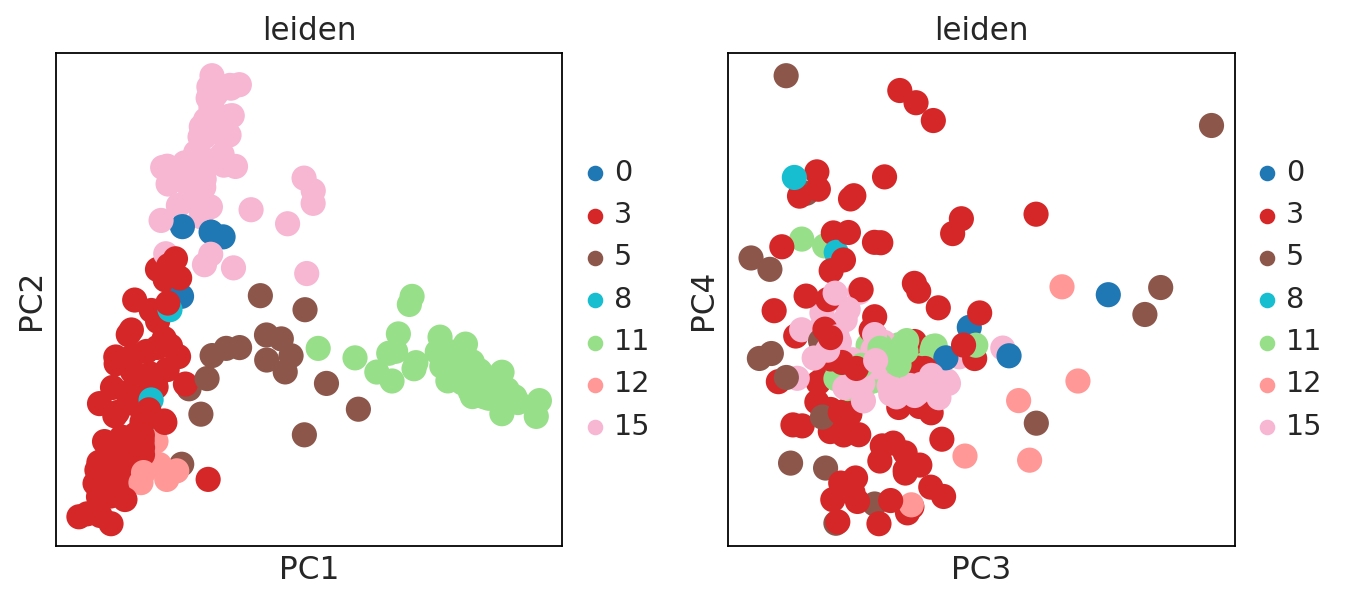

In [ ]:
# adata_sub = adata_npp[newdict[25],:]
# sc.tl.pca(adata_sub,n_comps=50)
# sc.pp.neighbors(adata_sub)
# sc.tl.umap(adata_sub)
sc.pl.umap(adata_sub,color='leiden')
sc.pl.pca(adata_sub, components=['1,2','3,4'], color='leiden')


In [ ]:
adata_npp.obs['label_lda_'] = adata_npp.obs['label_lda'].cat.rename_categories(
                                {16:'CD4 Memory',15: "CD4 Naive",6:'CD14 Mono',25:'cDC2',31:'NK',10:'Memory B',12:'Naive B',32:'CD16 Mono',19:'CD8 Naive',20:'CD8 memory',28:'CD8 Effector_1',14:'CD8 Effector_2'})
adata_npp.obs['label_lda_'].cat.remove_categories([24],inplace=True)

In [ ]:
adata_npp.obs['label_lda_'] = adata_npp.obs['label_lda_'].cat.reorder_categories(new_categories=['CD4 TEM', 'CD4 Naive', 'CD8 Naive', 'CD8 TCM', 'CD8 TEM' ])

/tmp/ipykernel_3251821/2238412075.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  label_latent = pd.Series(index=adata_new.obs_names)


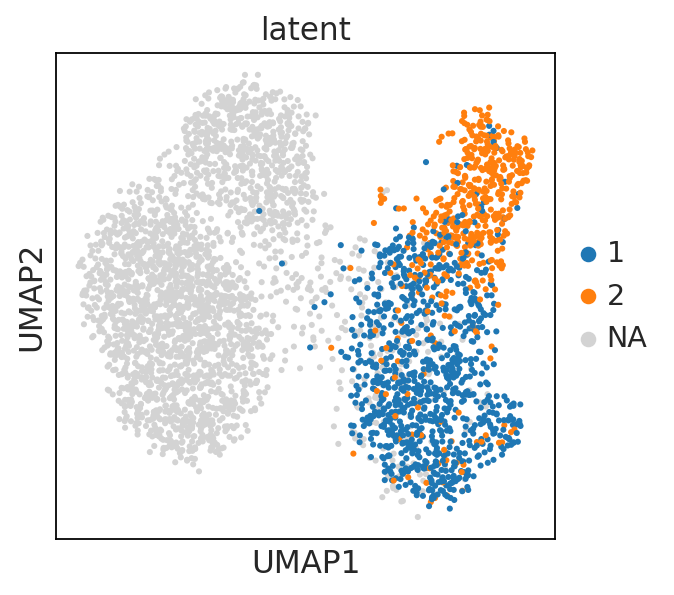

In [ ]:
label_latent = pd.Series(index=adata_new.obs_names)
label_latent.loc[newdict[5]] = '1'
label_latent.loc[newdict[6]] = '2'

adata_npp.obs['latent'] = label_latent
sc.pl.umap(adata_npp,color='latent')

In [ ]:
adata_npp.uns_keys

<bound method AnnData.uns_keys of AnnData object with n_obs × n_vars = 6196 × 33538
    obs: 'label_l1', 'label_l2', 'donor', 'time', 'label_l3', 'lane', 'n_genes', 'label_lda', 'label_lda_'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'label_lda_colors', 'label_l2_colors', 'label_lda__colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'>

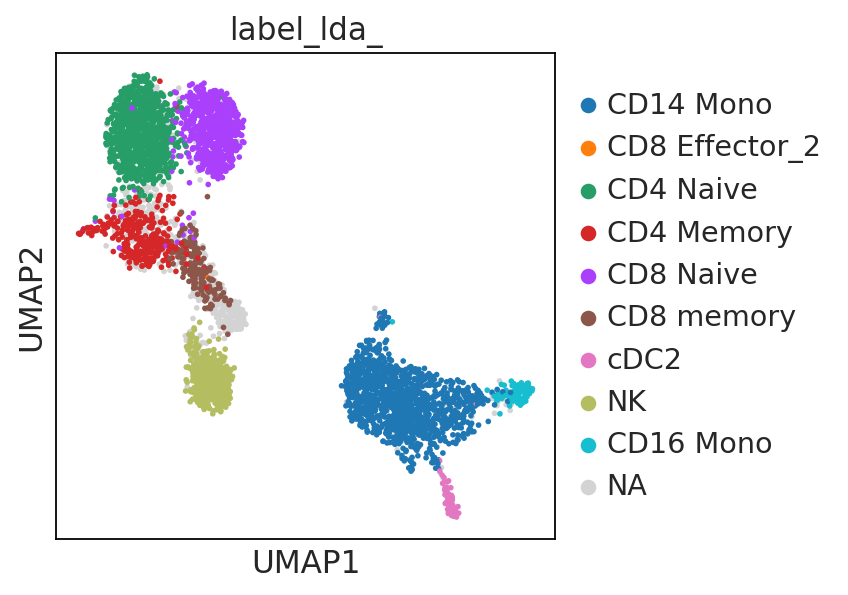

In [ ]:
# idnew = '2_2'
# label = pd.read_csv('../simulator_out/droplets_composition_'+idnew+'.csv')
# label.index = label.index.astype(str)
# label['cell_type'] = label.loc[:,'0'].astype(str)
# adata_npp.obs['label'] = label['cell_type']

# label = pd.read_csv('../data/bmmc/BMMC_2_label.csv',index_col=0)
# adata_npp.obs['label'] = label['gating'].astype(str)

sc.pl.umap(adata_npp,color='label_lda_')

In [ ]:
label = pd.read_csv('../data/bmmc/bmmc2_new gating_cluster.csv',index_col=0)


In [ ]:
label.index = [x.split(':')[0]+'.'+x.split(':')[1] for x in label.index]
label.index = [x.split('-')[0]+'.'+x.split('-')[1] for x in label.index]

In [ ]:
label.loc[:,'gating'] = label.iloc[:,1]

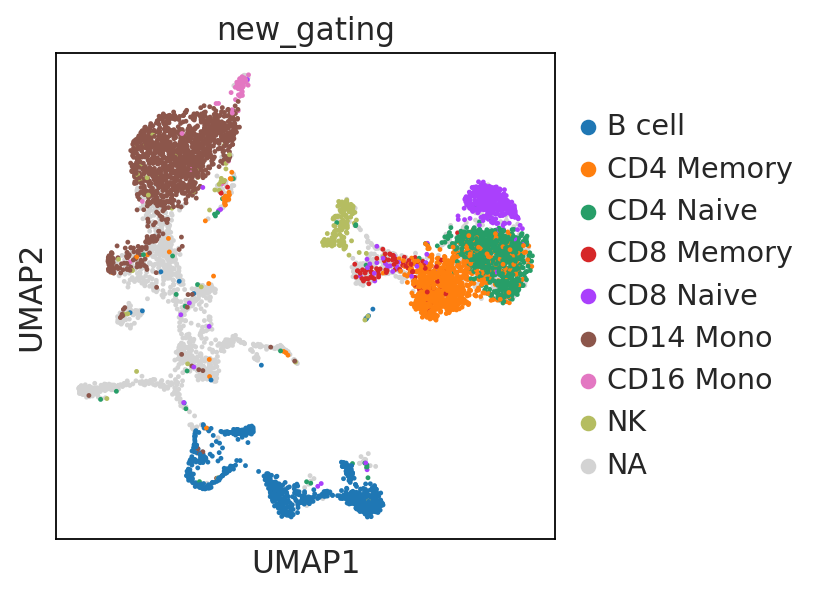

In [ ]:
adata_npp.obs['new_gating'] = label['New gating']
sc.pl.umap(adata_npp,color='new_gating')

In [ ]:
adata_npp.obs['new_gating']

2        NaN
6        NaN
7        NaN
11       NaN
12       NaN
        ... 
20281    NaN
20283    NaN
20284    NaN
20285    NaN
20286    NaN
Name: new_gating, Length: 9578, dtype: object

In [ ]:
label['citesort2'] = adata_npp.obs['label_lda_']

In [ ]:
label.to_csv('../data/bmmc/BMMC_2_label.csv')